# ProGAN - GAN Progressiva

A ProGAN (Progressive Growing of GANs) é uma variante de rede generativa adversa projetada para gerar imagens de alta resolução de forma progressiva e estável. Algumas de suas principais características:

- Começa gerando imagens muito pequenas (4x4 pixels) e gradualmente aumenta a resolução em um processo multi-estágio de treinamento.

- Adiciona camadas ao gerador e discriminador à medida que aumenta a resolução. Isso estabiliza o processo de treinamento.

- Usa uma tecnologia de mini-lotes durante todo o processo de treinamento, mesmo nas primeiras fases de baixa resolução. Isso fornece informações de gradiente mais precisas.  

- Emprega normalização por pixel, fazendo pixels vizinhos interagirem menos no espaço latente. Isso reduz artefatos e manchas.

- Gera imagens com mais resolução e qualidade do que outros métodos de GAN, aproximando-se muito das imagens reais.

- Pode ser treinada continuamente e produzir amostras cada vez melhores à medida que o treinamento avança.


A **ProGAN** utiliza uma abordagem de treinamento de crescimento progressivo.
A ideia é aumentar progressivamente tanto o gerador quanto o discriminador:
* a partir de uma resolução baixa, adicionamos novas camadas que modelam detalhes cada vez mais finos à medida que o treinamento avança.
* Isso além de estabilizar acelera o treinamento, permitindo produzir imagens em maior qualidade.

Para mais detalhes, veja o paper oficial: https://arxiv.org/abs/1710.10196


Adaptado de: https://github.com/tkarras/progressive_growing_of_gans

Utilizaremos o modelo treinado por Kerras. O modelo em questão foi treinado com faces de celebridades, usando o dataset [CelebA-HQ](https://paperswithcode.com/dataset/celeba-hq), que consiste de 30000 imagens no tamanho 1024×1024 pixels.




In [ ]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py37" --user

--2023-03-28 00:37:25--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104996770 (100M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>] 100.13M   161MB/s    in 0.6s    

2023-03-28 00:37:26 (161 MB/s) - ‘mini.sh’ saved [104996770/104996770]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2022.3.29=h06a4308_1
    - certifi==2021.10.8=py37h06a4308_2
    - cffi==1.15.0=py37hd667e15_1
    - charset-normalizer==2.0.4=pyhd3eb1b0_0
    - colorama==0.4.4

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

## [ Atualização Colab ]

`[ ! ] Importante:` após uma atualização no Colab em outubro de 2022, passou a ocorrer problemas de incompatibilidade ao usar as GPUs disponibilizadas pelo Colab com a versão do Tensorflow usada pelo repositório oficial da GAN. Isso é resultado de um conflito entre as versões do **CUDA** e do **cuDNN**, o que faz com que o Tensorflow não reconheça a GPU disponível e portanto gere erros ao fazer a leitura dos pesos do modelo pré-treinado (que exige o uso de GPU).

Para poder carregar o modelo pré-treinado no Colab, precisamos deixar o CUDA na versão 10 e o cuDNN na versão 7.6

In [ ]:
!nvidia-smi  # exibe informações sobre a GPU que foi associada para a sua sessão

Mon Mar 27 20:56:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Para fazer o uso dessas versões específicas do CUDA e cuDNN, precisamos executar os seguintes comandos conforme mostraremos abaixo

> **Versão do CUDA**

In [ ]:
# Para remover a versão atual do CUDA

!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-docker2' for glob 'nvidia*'
Note, selecting 'nvidia-headless-525-server' for glob 'nvidia*'
Note, selecting 'nvidia-headless-530-open' for glob 'nvidia*'
Note, selecting 'nvidia-fs-prebuilt' for glob 'nvidia*'
Note, selecting 'nvidia-driver-530-open' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-headless-no-dkms-515-open' for glob 'nvidia*'
Note, 

In [ ]:
# Para instalar a versão 10 do CUDA

!wget  --no-clobber https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get install cuda-10-0

In [ ]:
# Exibe a versão do CUDA

!nvcc --version

> **Versão do cuDNN**

Para instalar a versão específica do cuDNN, você precisa antes executar o comando abaixo que irá exibir todas as opções disponíveis que são compatíveis com a versão do CUDA que você tem instalado.

Você deve copiar aquilo que está ao lado de onde diz `Candidate:` - que, nesse nosso caso será `7.6.5.32-1+cuda10.2`

Copie o nome dessa versão pois usaremos no comando seguinte   


In [ ]:
!sudo apt-cache policy libcudnn7

Agora, você precisa colocar ao lado de cada um dos comandos abaixo aquilo que copiou:
* `!sudo apt install libcudnn7=`
* `!sudo apt install libcudnn7-dev=`

Ou seja, estamos dizendo que queremos instalar o `libcudnn7` e `libcudnn7-dev` naquela versão específica que é compatível com a CUDA instalada no Colab.

In [ ]:
!sudo apt install libcudnn7=7.6.5.32-1+cuda10.2
!sudo apt install libcudnn7-dev=7.6.5.32-1+cuda10.2

## Instalação das bibliotecas

In [ ]:
!pip uninstall tensorflow
!pip uninstall tensorflow-gpu

In [ ]:
!pip install tensorflow==1.14
!pip install tensorflow-gpu==1.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 54 kB/s 
     |████████████████████████████████| 3.1 MB 55.6 MB/s 
     |████████████████████████████████| 5.0 MB 55.5 MB/s 
     |████████████████████████████████| 302 kB 77.1 MB/s 
     |████████████████████████████████| 126 kB 60.9 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 488 kB 54.1 MB/s 
     |████████████████████████████████| 75 kB 5.1 MB/s 
     |████████████████████████████████| 57 kB 6.9 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 4.3 MB 67.7 MB/s 
     |████████████████████████████████| 93 kB 2.9 MB/s 
     |████████████████████████████████| 233 kB 76.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377.1 MB 9.0 kB/s 

In [ ]:
!git clone https://github.com/tkarras/progressive_growing_of_gans.git

Cloning into 'progressive_growing_of_gans'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 170 (delta 1), reused 4 (delta 1), pack-reused 164
Receiving objects: 100% (170/170), 356.84 KiB | 17.84 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
#!python -m pip install --upgrade pip
!python3 -m pip install cryptography==38.0.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
sh = """
curl ipinfo.io; echo
if ! hash ping &>/dev/null; then
  echo "Installing ping tools ..."
  apt-get install iputils-ping -y &>/dev/null
fi
curl ninh.js.org/speed.sh -sL | bash
"""
with open('script.sh', 'w') as file:
  file.write(sh)

!bash script.sh

'/usr/local/lib/python3.9/dist-packages/tensorflow/__init__.py'

In [ ]:
import pickle
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
from PIL import Image
import cv2

In [ ]:
!wget https://raw.githubusercontent.com/tkarras/progressive_growing_of_gans/master/tfutil.py
import tfutil

--2022-10-24 20:34:36--  https://raw.githubusercontent.com/tkarras/progressive_growing_of_gans/master/tfutil.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37013 (36K) [text/plain]
Saving to: ‘tfutil.py’

tfutil.py           100%[===================>]  36.15K  --.-KB/s    in 0s      

2022-10-24 20:34:37 (106 MB/s) - ‘tfutil.py’ saved [37013/37013]



## Download do modelo pré-treinado

In [ ]:
import gdown

In [ ]:
modelo_celeb = 'karras2018iclr-celebahq-1024x1024.pkl'
gdown.download('https://drive.google.com/uc?id=188K19ucknC6wg1R6jbuPEhTq9zoufOx4', modelo_celeb)

Downloading...
From: https://drive.google.com/uc?id=188K19ucknC6wg1R6jbuPEhTq9zoufOx4
To: /content/karras2018iclr-celebahq-1024x1024.pkl
100%|██████████| 277M/277M [00:05<00:00, 51.0MB/s]


'karras2018iclr-celebahq-1024x1024.pkl'

## Carregamento do modelo

O arquivo .pkl contém 3 instâncias da rede (tfutil.Network)

* G = snapshot do gerador - util caso queira continuar com o treinamento
* D = snapshot do discriminador - util caso queira continuar também com o treinamento
* Gs = instância do gerador que produz os melhores resultados, é esse que usaremos para gerar as imagens

In [ ]:
session = tf.InteractiveSession()

In [ ]:
with open(modelo_celeb, 'rb') as file:
  G, D, Gs = pickle.load(file)

## Testes com o modelo

Demostração dos vetores latentes: https://youtu.be/G06dEcZ-QTg?t=48 (ver aos 00:48)

### Criação do vetor latente

In [ ]:
def retorna_latentes(shape_entrada):
  latentes = np.random.RandomState(1000).randn(1000, shape_entrada)
  #print(latentes.shape)
  #print(len(latentes))
  #print(latentes[0].shape)
  #print(latentes[0])
  latentes = latentes[[477, 56, 83, 887, 583, 391, 86, 340, 341, 415]]
  #print(latentes[0])
  return latentes

In [ ]:
Gs.input_shapes[0][1:]

[512]

In [ ]:
latentes = retorna_latentes(*Gs.input_shapes[0][1:])

In [ ]:
labels = np.zeros([latentes.shape[0]] + Gs.input_shapes[1][1:])

In [ ]:
labels.shape

(10, 0)

### Geração de imagens

Formato [NCHW](https://oneapi-src.github.io/oneDNN/dev_guide_understanding_memory_formats.html#nchw) para [NHWC](https://oneapi-src.github.io/oneDNN/dev_guide_understanding_memory_formats.html#nhwc). Mais informações sobre esses formatos: https://oneapi-src.github.io/oneDNN/dev_guide_understanding_memory_formats.html#nchw

In [ ]:
imagens = Gs.run(latentes, labels)

In [ ]:
imagens.shape

(10, 3, 1024, 1024)

In [ ]:
imagens = np.clip(np.rint((imagens + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # de [-1,1] -> [0,255]
imagens = imagens.transpose(0, 2, 3, 1) # de NCHW -> NHWC

In [ ]:
imagens.shape

(10, 1024, 1024, 3)

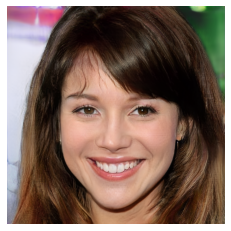

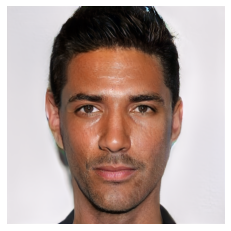

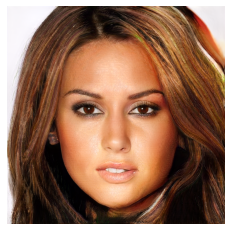

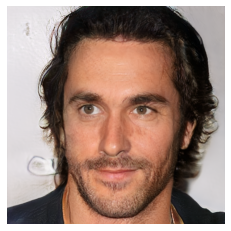

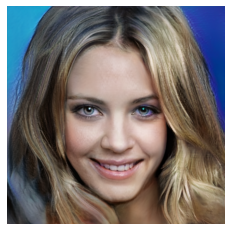

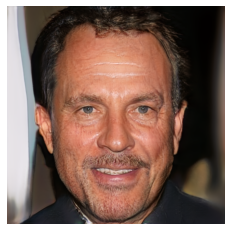

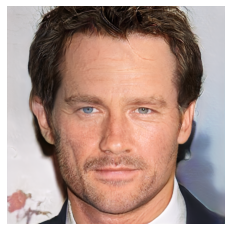

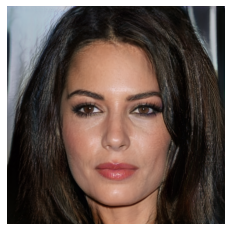

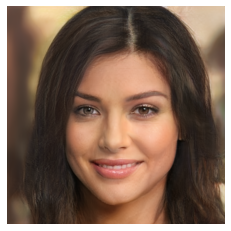

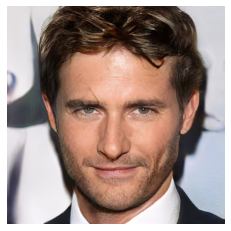

In [ ]:
for idx in range(imagens.shape[0]):
  img = Image.fromarray(imagens[idx], 'RGB')
  plt.axis('off')
  plt.imshow(img)
  plt.show()

In [ ]:
for idx in range(imagens.shape[0]):
  Image.fromarray(imagens[idx], 'RGB').save('img_%d.png' % idx)

## Interpolação entre dois vetores latentes


In [ ]:
def interpolar(A, B, num_vetores):
  assert len(A.shape) == 1
  assert len(B.shape) == 1

  latentes = [np.copy(A)]

  latente_diferenca = (B - A) / (num_vetores + 1)

  for idx in range(num_vetores):
    latente_atual = np.copy(latentes[-1])
    latente_atual = latente_atual + latente_diferenca
    latente_atual = np.expand_dims(latente_atual, axis = 0)
    latentes = np.concatenate((latentes, latente_atual), axis = 0)
  latentes = np.concatenate((latentes, np.expand_dims(B, axis = 0)), axis = 0)
  return latentes

In [ ]:
def latentes_interp(shape_entrada):
  vetor_A = 415
  vetor_B = 341
  latentes = np.random.RandomState(1000).randn(1000, shape_entrada)
  latentes = interpolar(latentes[vetor_A], latentes[vetor_B], 8)
  return latentes

In [ ]:
latentes = latentes_interp(*Gs.input_shapes[0][1:])
latentes.shape

(10, 512)

In [ ]:
labels = np.zeros([latentes.shape[0]] + Gs.input_shapes[1][1:])
imagens = Gs.run(latentes, labels)

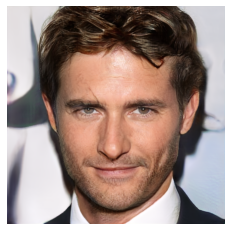

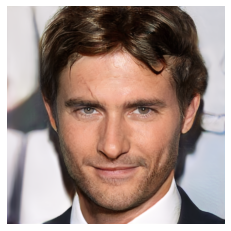

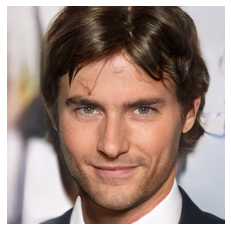

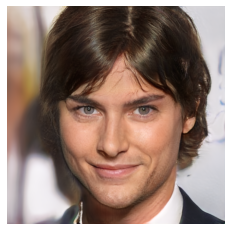

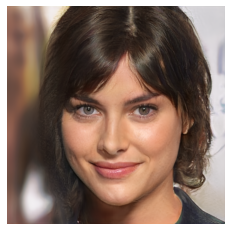

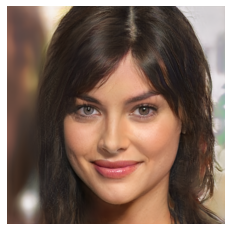

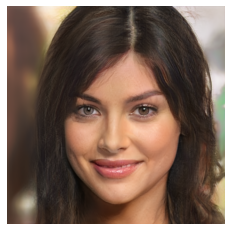

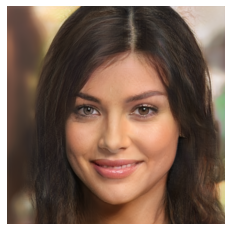

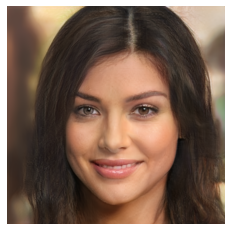

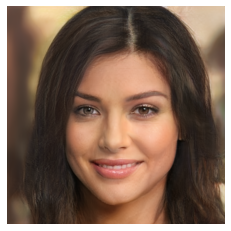

In [ ]:
imagens = np.clip(np.rint((imagens + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8)   # de [-1,1] para => [0,255]
imagens = imagens.transpose(0, 2, 3, 1)                                                  # de NCHW para => NHWC

for idx in range(imagens.shape[0]):
    Image.fromarray(imagens[idx], 'RGB').save('img_%d.png' % idx)

for idx in range(imagens.shape[0]):
    img = Image.fromarray(imagens[idx], 'RGB')  # converte para RGB
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [ ]:
import imageio # pip -q install imageio
import glob

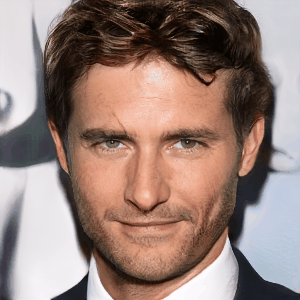

In [ ]:
arquivo_saida = 'animacao.gif'
with imageio.get_writer(arquivo_saida, mode = 'I', duration = 0.15) as writer:
  frames = glob.glob('img_*.png')
  frames = sorted(frames)
  for i, nome_img in enumerate(frames):
    img_animada = imageio.imread(nome_img)
    img_animada = cv2.resize(img_animada, (300, 300))
    writer.append_data(img_animada)
from IPython.display import Image
Image(open('animacao.gif', 'rb').read())

In [ ]:
session.close()